In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import wfdb
import os
from time import time as time
from tqdm import tqdm
import copy
from scipy import signal
import pickle
import ast
from torch import nn
import torch
from functools import reduce
from operator import __add__
import torch.nn.functional as F
from torchmetrics.classification import MultilabelF1Score,MultilabelPrecision,MultilabelRecall,MultilabelAccuracy
import pickle 

import models


In [2]:
os.chdir('/athena/sablab/scratch/prj4005/XML')

In [3]:
csv = pd.read_csv('physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv')
root_dir = 'physionet.org/files/ptb-xl/1.0.3'

In [13]:
class PTBDataset(Dataset):
  def __init__(
      self,
      csv = 'physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv',
      root_dir = 'physionet.org/files/ptb-xl/1.0.3',
      scp_csv = 'physionet.org/files/ptb-xl/1.0.3/scp_statements.csv',
      mode = 'append'):
    df = pd.read_csv(csv)
    
    self.root_dir = root_dir
    self.mode = mode
    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv(scp_csv, index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    def aggregate_diagnostic(y_dic):
      tmp = []
      for key in y_dic.keys():
          if key in agg_df.index:
              tmp.append(agg_df.loc[key].diagnostic_class)
      
      return list(set(tmp))

    df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
    df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)
    self.data = df
    
    index = np.where(self.data.strat_fold.isin([0,1,2,3,4,5,6,7,8]))
    self.train = self.data.iloc[index]
    index = np.where(self.data.strat_fold.isin([9]))
    self.val = self.data.iloc[index]
    index = np.where(self.data.strat_fold.isin([10]))
    self.test = self.data.iloc[index]

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.toint()
    fname_1 = self.root_dir+os.sep+self.data.iloc[idx].filename_lr
    sample_1,head = wfdb.rdsamp(str(fname_1))
    label_1 = self.data["diagnostic_superclass"].iloc[idx]
    label = np.zeros(5,dtype = np.int64)
    dic = {'NORM':0,'MI':1,'STTC':2,'CD':3,'HYP':4}
    for i in label_1:
      label[dic[i]] = 1
    return np.squeeze(sample_1),label

  def set_fold(self,fold):
    if fold == "Train":
      self.data = self.train
    elif fold == "Val":
      self.data = self.val
    elif fold == "Test":
      self.data = self.test
    else:
      raise Exception(f"No fold named: {fold}")
    return self

  

In [6]:
dataset = PTBDataset()

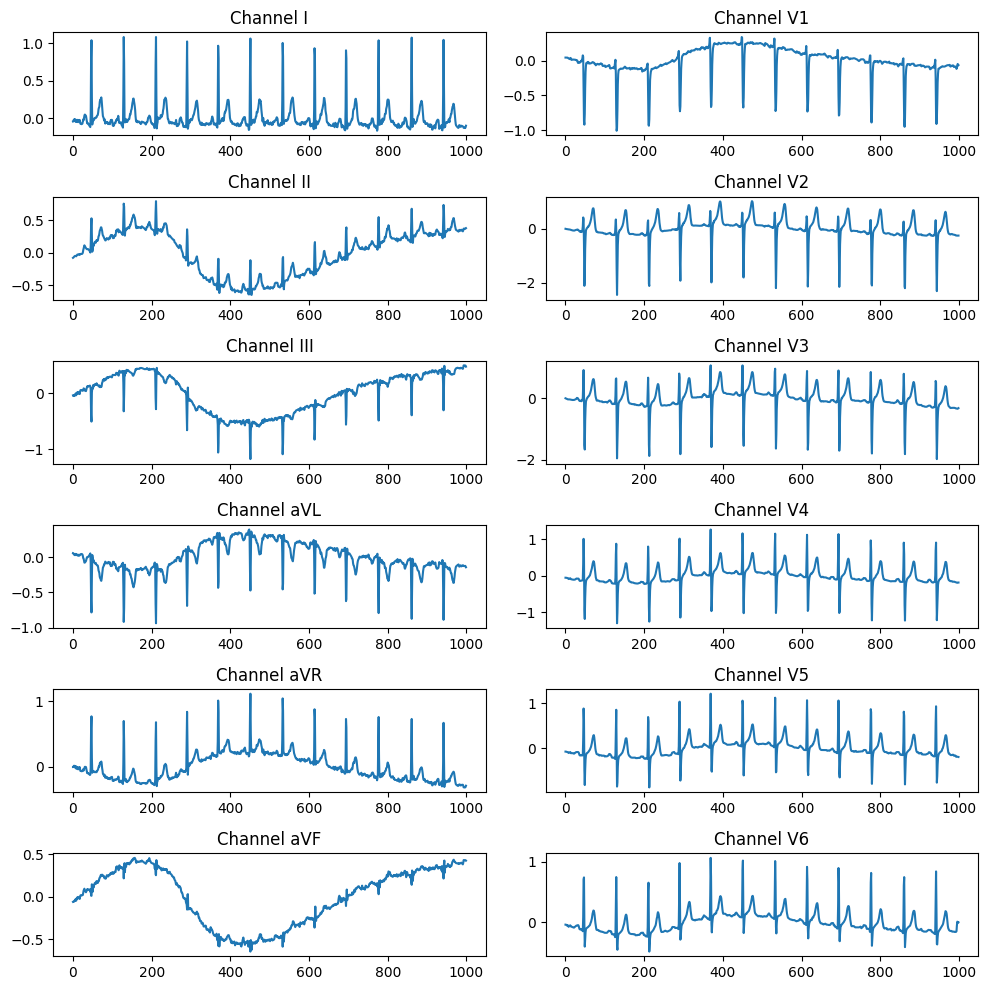

In [97]:
fig,ax = plt.subplots(6,2,figsize=(10,10))
chan = {0:'I',1:'II',2:'III',3:'aVL',4:'aVR',5:'aVF',6:'V1',7:'V2',8:'V3',9:'V4',10:'V5',11:'V6'}
for i in range(12):
    ax[i-6*(i//6)][i//6].plot(dataset[7][0][:,i])
    ax[i-6*(i//6)][i//6].set_title(f'Channel {chan[i]}')


fig.tight_layout()

In [9]:
class Net(nn.Module):


# Convolution as a whole should span at least 1 beat, preferably more
# Input shape = (12,2500)

    def __init__(self):
        super(Net, self).__init__()
        # kernel
        #first layer picking out most basic pattern, 24 output means = 24 channels and 24 different signals for model to detect 
        #these are the lego blocks that get put together in further layer to detect more detailed features
        #can put into matplotlib and see the features that the first layer is learning 
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=20, kernel_size=15),
            nn.BatchNorm1d(20),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(20, 40, 15),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2))

        self.conv3 = nn.Sequential(
            nn.Conv1d(40, 50, 15), 
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 3, stride = 1))
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(50, 75, 15),
            nn.BatchNorm1d(75),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv1d(75, 90, 15),
            nn.BatchNorm1d(90),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 1))

        self.conv6 = nn.Sequential(
            nn.Conv1d(90, 110, 15),
            nn.BatchNorm1d(110),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 2, stride = 1))

        # NOTE: Why you do not use activations on top of your linear layers?
        # NOTE: Of course the last layer nn.Linear(10,1), does not need activation since you are using BCEWithLogitsLoss.
        # NOTE: Too many layers can increae the chance of overfitting is the data is not large enough. Also, using activations is crucial.
        self.fc1 = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), #takes 1176 channels and averages to 110
            nn.Flatten(),
            nn.Linear(110, 70),
            nn.ReLU(),
            nn.Linear(70,35),
            nn.ReLU(),
            nn.Linear(35,10),
            nn.ReLU(),
            nn.Linear(10,5))

    def forward(self, x):
        # print(x.shape)
        x = x.view(x.shape[0], 12,-1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
#         out = out.view(x.shape[0], out.size(1) * out.size(2))
        out = self.fc1(out)
        return out

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device= torch.device('cuda')):
    since = time()
    val_acc_history = []
    train_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)
    Accuracy = MultilabelAccuracy(num_labels=5,average='macro').to(device)
    F1 = MultilabelF1Score(num_labels=5, average='macro').to(device)
    Precision = MultilabelPrecision(num_labels=5, average='macro').to(device)
    Recall = MultilabelRecall(num_labels=5, average='macro').to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0
            running_corrects = 0
            running_f1 = 0
            running_precision = 0
            running_recall = 0

            # Iterate over data.
            for input,label in tqdm(dataloaders[phase]):
                input = input.to(device=device, dtype=torch.float).permute(0,2,1)
                label = label.to(device=device, dtype=torch.float)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss                    
                    outputs = model(input)
                    loss = criterion(outputs, label)
                    #Predictions from Binary Cross Entropy with Logits

                    preds = torch.squeeze(torch.sigmoid(outputs))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * input.size(0)
                running_acc += Accuracy(preds, label.data) * input.size(0)
                running_f1 += F1(preds, label.data) * input.size(0)
                running_precision += Precision(preds, label.data) * input.size(0)
                running_recall += Recall(preds, label.data) * input.size(0)
                
                running_corrects += torch.sum(preds == label.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_acc / len(dataloaders[phase].dataset)
            epoch_f1 = running_f1 / len(dataloaders[phase].dataset)
            epoch_precision = running_precision / len(dataloaders[phase].dataset)
            epoch_recall = running_recall / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(phase, epoch_f1, epoch_precision, epoch_recall))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [14]:
batch_size = 32
train_data = PTBDataset()
train_data = train_data.set_fold("Train")
val_data = PTBDataset()
val_data = val_data.set_fold("Val")
test_data = PTBDataset()
test_data = test_data.set_fold("Test")
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
dataloaders = {'train':trainLoader,'val':valLoader}




In [5]:
import importlib
importlib.reload(models)

<module 'models' from '/athena/sablab/scratch/prj4005/XML/models.py'>

In [16]:
weights = np.array([9514,5469,5235,4898,2649])
weights = (21801-weights)/weights
print(weights)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights).float().to('cuda'))
# mod = models.resnetsmall(pretrained= False, num_classes = 5)
optimizer = torch.optim.Adam(mod.parameters(),lr=0.05,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

[1.29146521 2.98628634 3.16446991 3.45100041 7.22989807]


In [127]:
mod, val_acc_history, train_acc_history = train_model(mod, dataloaders, criterion, optimizer, num_epochs = 50, device = torch.device('cuda'))

  0%|          | 0/545 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.8502 Acc: 0.7295
train F1: 0.5506 Precision: 0.4773 Recall: 0.7437


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6966 Acc: 0.8148
val F1: 0.6429 Precision: 0.6044 Recall: 0.7573
Epoch 1/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.7260 Acc: 0.7789
train F1: 0.6068 Precision: 0.5342 Recall: 0.7789


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6840 Acc: 0.8230
val F1: 0.6446 Precision: 0.6109 Recall: 0.7517
Epoch 2/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6971 Acc: 0.7920
train F1: 0.6216 Precision: 0.5521 Recall: 0.7874


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6607 Acc: 0.8224
val F1: 0.6524 Precision: 0.5917 Recall: 0.7793
Epoch 3/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6703 Acc: 0.8030
train F1: 0.6390 Precision: 0.5692 Recall: 0.8021


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6427 Acc: 0.8453
val F1: 0.6742 Precision: 0.6423 Recall: 0.7661
Epoch 4/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6573 Acc: 0.8132
train F1: 0.6483 Precision: 0.5834 Recall: 0.7992


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6151 Acc: 0.8351
val F1: 0.6739 Precision: 0.6042 Recall: 0.8133
Epoch 5/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6387 Acc: 0.8195
train F1: 0.6558 Precision: 0.5929 Recall: 0.8039


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6425 Acc: 0.7918
val F1: 0.6359 Precision: 0.5464 Recall: 0.8248
Epoch 6/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6255 Acc: 0.8241
train F1: 0.6630 Precision: 0.5975 Recall: 0.8133


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5903 Acc: 0.8479
val F1: 0.6884 Precision: 0.6310 Recall: 0.7961
Epoch 7/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6104 Acc: 0.8222
train F1: 0.6647 Precision: 0.5939 Recall: 0.8230


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6164 Acc: 0.8601
val F1: 0.6975 Precision: 0.6611 Recall: 0.7750
Epoch 8/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.6099 Acc: 0.8268
train F1: 0.6683 Precision: 0.6046 Recall: 0.8157


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5836 Acc: 0.8290
val F1: 0.6742 Precision: 0.5954 Recall: 0.8306
Epoch 9/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5933 Acc: 0.8306
train F1: 0.6748 Precision: 0.6066 Recall: 0.8247


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6837 Acc: 0.8631
val F1: 0.6979 Precision: 0.6826 Recall: 0.7549
Epoch 10/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5896 Acc: 0.8272
train F1: 0.6706 Precision: 0.5992 Recall: 0.8270


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6271 Acc: 0.8534
val F1: 0.6918 Precision: 0.6474 Recall: 0.7860
Epoch 11/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5785 Acc: 0.8351
train F1: 0.6830 Precision: 0.6151 Recall: 0.8321


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5973 Acc: 0.8050
val F1: 0.6531 Precision: 0.5685 Recall: 0.8398
Epoch 12/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5781 Acc: 0.8321
train F1: 0.6795 Precision: 0.6089 Recall: 0.8335


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5786 Acc: 0.8383
val F1: 0.6800 Precision: 0.6260 Recall: 0.8201
Epoch 13/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5704 Acc: 0.8364
train F1: 0.6834 Precision: 0.6163 Recall: 0.8321


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5791 Acc: 0.8491
val F1: 0.6940 Precision: 0.6388 Recall: 0.8077
Epoch 14/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5636 Acc: 0.8383
train F1: 0.6868 Precision: 0.6183 Recall: 0.8363


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6183 Acc: 0.7918
val F1: 0.6458 Precision: 0.5701 Recall: 0.8552
Epoch 15/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5577 Acc: 0.8387
train F1: 0.6881 Precision: 0.6191 Recall: 0.8364


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6120 Acc: 0.8092
val F1: 0.6576 Precision: 0.5769 Recall: 0.8430
Epoch 16/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5533 Acc: 0.8415
train F1: 0.6922 Precision: 0.6247 Recall: 0.8387


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5605 Acc: 0.8400
val F1: 0.6908 Precision: 0.6184 Recall: 0.8364
Epoch 17/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5504 Acc: 0.8398
train F1: 0.6895 Precision: 0.6210 Recall: 0.8399


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6681 Acc: 0.8375
val F1: 0.6761 Precision: 0.6055 Recall: 0.8101
Epoch 18/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5473 Acc: 0.8417
train F1: 0.6936 Precision: 0.6234 Recall: 0.8466


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6300 Acc: 0.8333
val F1: 0.6823 Precision: 0.6147 Recall: 0.8238
Epoch 19/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5390 Acc: 0.8448
train F1: 0.6986 Precision: 0.6306 Recall: 0.8469


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6803 Acc: 0.8510
val F1: 0.6819 Precision: 0.6430 Recall: 0.7811
Epoch 20/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5282 Acc: 0.8475
train F1: 0.7021 Precision: 0.6335 Recall: 0.8504


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6581 Acc: 0.8500
val F1: 0.6917 Precision: 0.6251 Recall: 0.8127
Epoch 21/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5263 Acc: 0.8476
train F1: 0.7024 Precision: 0.6336 Recall: 0.8501


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5981 Acc: 0.8559
val F1: 0.7052 Precision: 0.6598 Recall: 0.8174
Epoch 22/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5217 Acc: 0.8503
train F1: 0.7066 Precision: 0.6381 Recall: 0.8535


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7166 Acc: 0.8596
val F1: 0.6993 Precision: 0.6700 Recall: 0.7835
Epoch 23/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5189 Acc: 0.8475
train F1: 0.7037 Precision: 0.6345 Recall: 0.8548


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5986 Acc: 0.8605
val F1: 0.6944 Precision: 0.6594 Recall: 0.7737
Epoch 24/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5113 Acc: 0.8538
train F1: 0.7114 Precision: 0.6428 Recall: 0.8560


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6271 Acc: 0.8556
val F1: 0.7018 Precision: 0.6596 Recall: 0.8031
Epoch 25/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.5043 Acc: 0.8540
train F1: 0.7134 Precision: 0.6435 Recall: 0.8617


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.5918 Acc: 0.8545
val F1: 0.7035 Precision: 0.6491 Recall: 0.8154
Epoch 26/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4992 Acc: 0.8549
train F1: 0.7143 Precision: 0.6448 Recall: 0.8596


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6146 Acc: 0.8512
val F1: 0.7032 Precision: 0.6491 Recall: 0.8156
Epoch 27/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4953 Acc: 0.8560
train F1: 0.7154 Precision: 0.6473 Recall: 0.8612


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6548 Acc: 0.8632
val F1: 0.7067 Precision: 0.6808 Recall: 0.7815
Epoch 28/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4887 Acc: 0.8573
train F1: 0.7180 Precision: 0.6496 Recall: 0.8632


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6386 Acc: 0.8582
val F1: 0.7019 Precision: 0.6495 Recall: 0.8086
Epoch 29/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4857 Acc: 0.8571
train F1: 0.7186 Precision: 0.6493 Recall: 0.8677


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6057 Acc: 0.8481
val F1: 0.6951 Precision: 0.6269 Recall: 0.8282
Epoch 30/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4834 Acc: 0.8611
train F1: 0.7235 Precision: 0.6559 Recall: 0.8656


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6543 Acc: 0.8522
val F1: 0.6973 Precision: 0.6364 Recall: 0.8198
Epoch 31/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4728 Acc: 0.8593
train F1: 0.7233 Precision: 0.6523 Recall: 0.8717


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6186 Acc: 0.8532
val F1: 0.7032 Precision: 0.6419 Recall: 0.8251
Epoch 32/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4668 Acc: 0.8621
train F1: 0.7266 Precision: 0.6586 Recall: 0.8718


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6741 Acc: 0.8525
val F1: 0.6969 Precision: 0.6469 Recall: 0.8091
Epoch 33/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4594 Acc: 0.8639
train F1: 0.7291 Precision: 0.6575 Recall: 0.8765


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6172 Acc: 0.8582
val F1: 0.7054 Precision: 0.6543 Recall: 0.8134
Epoch 34/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4582 Acc: 0.8660
train F1: 0.7321 Precision: 0.6636 Recall: 0.8762


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6965 Acc: 0.8632
val F1: 0.7069 Precision: 0.6683 Recall: 0.7895
Epoch 35/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4597 Acc: 0.8664
train F1: 0.7333 Precision: 0.6674 Recall: 0.8735


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6810 Acc: 0.8492
val F1: 0.6957 Precision: 0.6326 Recall: 0.8182
Epoch 36/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4478 Acc: 0.8688
train F1: 0.7355 Precision: 0.6687 Recall: 0.8757


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7793 Acc: 0.8550
val F1: 0.7036 Precision: 0.6756 Recall: 0.7912
Epoch 37/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4478 Acc: 0.8679
train F1: 0.7364 Precision: 0.6703 Recall: 0.8795


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6846 Acc: 0.8359
val F1: 0.6843 Precision: 0.6033 Recall: 0.8459
Epoch 38/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4360 Acc: 0.8735
train F1: 0.7440 Precision: 0.6780 Recall: 0.8787


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6376 Acc: 0.8302
val F1: 0.6797 Precision: 0.6043 Recall: 0.8428
Epoch 39/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4332 Acc: 0.8726
train F1: 0.7436 Precision: 0.6770 Recall: 0.8820


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6301 Acc: 0.8506
val F1: 0.6887 Precision: 0.6323 Recall: 0.8004
Epoch 40/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4316 Acc: 0.8725
train F1: 0.7425 Precision: 0.6754 Recall: 0.8830


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7082 Acc: 0.8577
val F1: 0.6962 Precision: 0.6517 Recall: 0.7855
Epoch 41/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4184 Acc: 0.8767
train F1: 0.7504 Precision: 0.6843 Recall: 0.8855


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7273 Acc: 0.8609
val F1: 0.7044 Precision: 0.6624 Recall: 0.7872
Epoch 42/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4207 Acc: 0.8737
train F1: 0.7468 Precision: 0.6756 Recall: 0.8923


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.6647 Acc: 0.8497
val F1: 0.7007 Precision: 0.6342 Recall: 0.8207
Epoch 43/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4091 Acc: 0.8784
train F1: 0.7541 Precision: 0.6852 Recall: 0.8927


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7731 Acc: 0.8557
val F1: 0.6920 Precision: 0.6507 Recall: 0.7801
Epoch 44/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4190 Acc: 0.8771
train F1: 0.7522 Precision: 0.6860 Recall: 0.8898


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7300 Acc: 0.8574
val F1: 0.6988 Precision: 0.6455 Recall: 0.8030
Epoch 45/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.4020 Acc: 0.8807
train F1: 0.7575 Precision: 0.6905 Recall: 0.8919


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.8305 Acc: 0.8598
val F1: 0.7005 Precision: 0.6578 Recall: 0.7847
Epoch 46/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.3971 Acc: 0.8825
train F1: 0.7607 Precision: 0.6948 Recall: 0.8950


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7298 Acc: 0.8421
val F1: 0.6844 Precision: 0.6268 Recall: 0.8147
Epoch 47/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.3968 Acc: 0.8834
train F1: 0.7606 Precision: 0.6953 Recall: 0.8921


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7534 Acc: 0.8591
val F1: 0.7010 Precision: 0.6565 Recall: 0.7881
Epoch 48/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.3851 Acc: 0.8862
train F1: 0.7661 Precision: 0.7004 Recall: 0.8961


  0%|          | 0/545 [00:00<?, ?it/s]

val Loss: 0.7870 Acc: 0.8611
val F1: 0.7026 Precision: 0.6648 Recall: 0.7899
Epoch 49/49
----------


  0%|          | 0/69 [00:00<?, ?it/s]

train Loss: 0.3830 Acc: 0.8874
train F1: 0.7684 Precision: 0.7019 Recall: 0.8987


100%|██████████| 69/69 [00:05<00:00, 12.63it/s]

val Loss: 0.7484 Acc: 0.8529
val F1: 0.6904 Precision: 0.6496 Recall: 0.7867
Training complete in 50m 57s
Best val Acc: 0.863216


In [128]:
import time as t

In [129]:
meta = f'Resnetsmall_{t.ctime().replace(" ","_")}'
pickle.dump(mod, open(f"{meta}_model.pkl", "wb"))
pickle.dump(val_acc_history, open(f"{meta}_val_acc_history.pkl", "wb"))
pickle.dump(train_acc_history, open(f"{meta}_train_acc_history.pkl", "wb"))

In [30]:
test_data = PTBDataset()
test_data = test_data.set_fold("Test")
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [50]:
def infer_omodel(model, dataloaders, criterion, optimizer, device= torch.device('cuda')):

    model = model.to(device)
    train_preds = []
    train_labels = []
    val_preds = []
    val_labels = []
    model.eval()

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        # Iterate over data.
        for input,label in tqdm(dataloaders[phase]):
            input = input.to(device=device, dtype=torch.float).permute(0,2,1)
            label = label.to(device=device, dtype=torch.float)
    
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                # Get model outputs and calculate loss                    
                outputs = model(input)
                preds = torch.squeeze(torch.sigmoid(outputs))
            if phase == 'train':
                train_preds.append(preds)
                train_labels.append(label)
            else:
                val_preds.append(preds)
                val_labels.append(label)


    return model, train_preds, train_labels, val_preds, val_labels

In [6]:
meta = '/athena/sablab/scratch/prj4005/XML/Resnetsmall_Fri_Apr_28_10:21:11_2023'
mod = pickle.load(open(f"{meta}_model.pkl", "rb"))
val_acc_history = pickle.load(open(f"{meta}_val_acc_history.pkl", "rb"))
train_acc_history = pickle.load(open(f"{meta}_train_acc_history.pkl", "rb"))



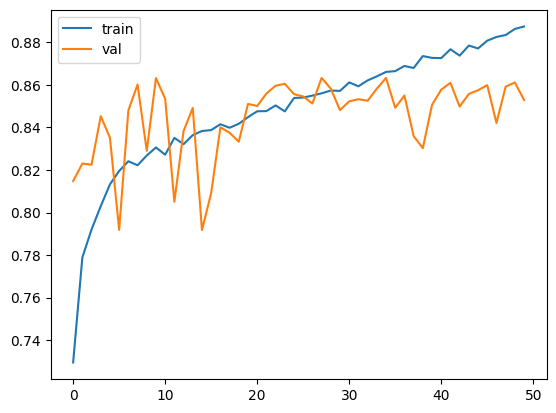

In [7]:
fig,ax = plt.subplots(1)
ax.plot(torch.tensor(train_acc_history).cpu().numpy(), label='train')
ax.plot(torch.tensor(val_acc_history).cpu().numpy(), label='val')
ax.legend()

In [51]:
mod, train_preds, train_labels, val_preds, val_labels = infer_omodel(mod, dataloaders, criterion, optimizer, device= torch.device('cuda'))

100%|██████████| 69/69 [00:03<00:00, 21.54it/s]


In [52]:
train_labels = torch.cat(train_labels)
train_preds = torch.cat(train_preds)
val_labels = torch.cat(val_labels)
val_preds = torch.cat(val_preds)

In [49]:
print(test_labels.shape)
print(test_preds.

torch.Size([2198, 5])
torch.Size([10990])


In [53]:

weighted_accuracy = torch.mean(torch.sum(torch.round(val_preds) == val_labels,dim =0)/val_labels.shape[0])
print(weighted_accuracy)

tensor(0.8632, device='cuda:0')


In [134]:
torch.round(val_preds)

tensor([[0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], device='cuda:0')

In [20]:
from sklearn.metrics import multilabel_confusion_matrix
cm =multilabel_confusion_matrix(torch.round(val_preds).cpu().numpy(), val_labels.cpu().numpy())

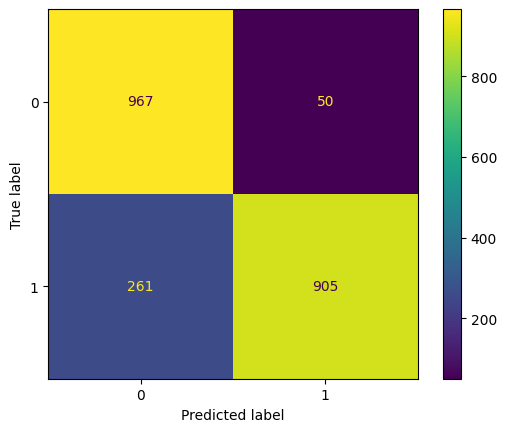

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm[0], display_labels = ['0','1']).plot()


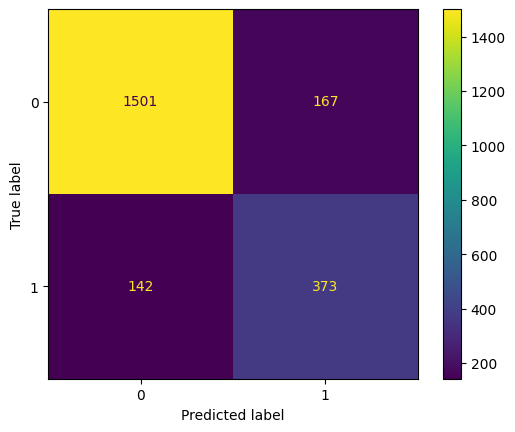

In [23]:
ConfusionMatrixDisplay(cm[1], display_labels = ['0','1']).plot()


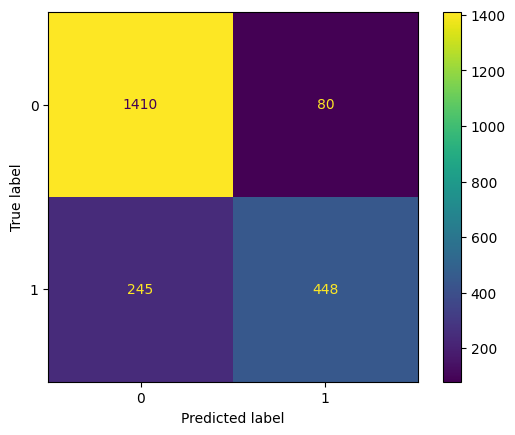

In [24]:
ConfusionMatrixDisplay(cm[2], display_labels = ['0','1']).plot()


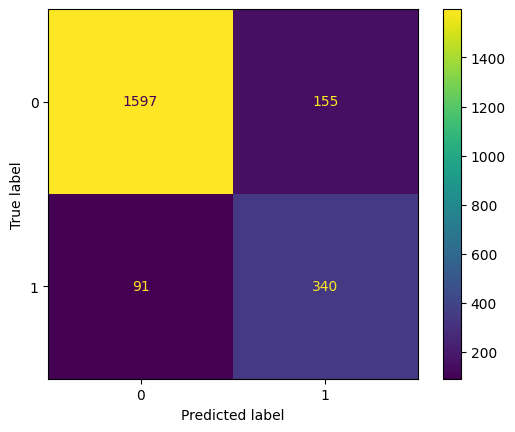

In [25]:
ConfusionMatrixDisplay(cm[3], display_labels = ['0','1']).plot()


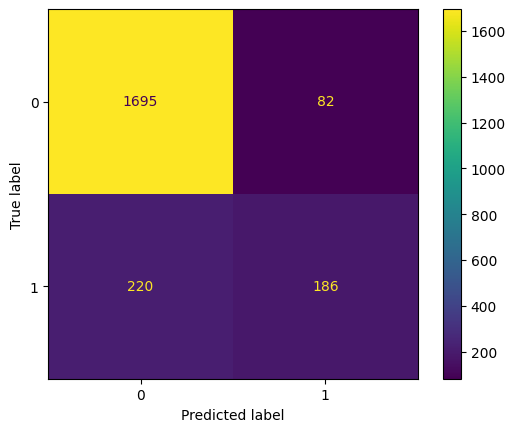

In [26]:
ConfusionMatrixDisplay(cm[4], display_labels = ['0','1']).plot()


In [27]:
from torchmetrics.classification import MultilabelAUROC
auroc = MultilabelAUROC(num_labels=5, average='macro')
auroc(torch.round(val_preds), val_labels.int())

tensor(0.8252, device='cuda:0')

In [11]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients  = {}
def getGradients(name):
    def hook(model, input, output):
        gradients[name] = output
    return hook

torch.Size([1, 1000, 12])


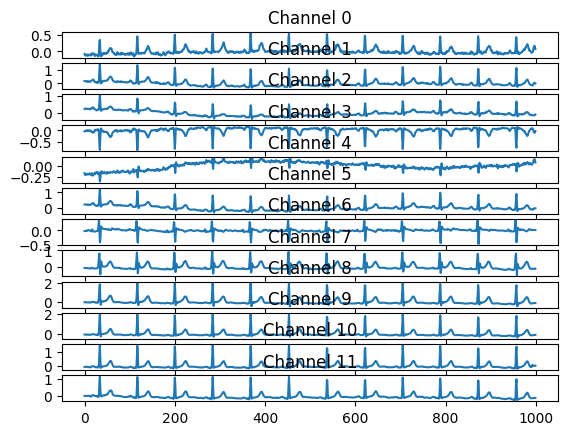

In [85]:
input,label = data_iter.next()
print(input.shape)
input = input.permute(0,2,1)
fig,ax = plt.subplots(12,1)
for i in range(12):
    ax[i].plot(input[0,i].cpu().numpy())
    ax[i].set_title(f'Channel {i}')

In [94]:
data_iter = iter(test_dataloader)
input,label = data_iter.next()
input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))
input.requires_grad = True
pred = mod(input)

# a dict to store the activations



/tmp/ipykernel_268652/1257868287.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))


In [95]:
pred[0][1].backward(retain_graph=True)

In [96]:
x = input.grad
x = x.cpu().numpy()

In [97]:
x.shape

(1, 12, 1000)

In [98]:
input = input.detach().cpu().numpy()

In [99]:
channel_influence = np.sum(np.abs(x),axis = 2)
print(channel_influence)

[[ 58.16659   80.78114   73.5336    69.27504   64.00385   81.8189
  100.39555   86.80102   48.54801   39.884705  55.359722  52.956448]]


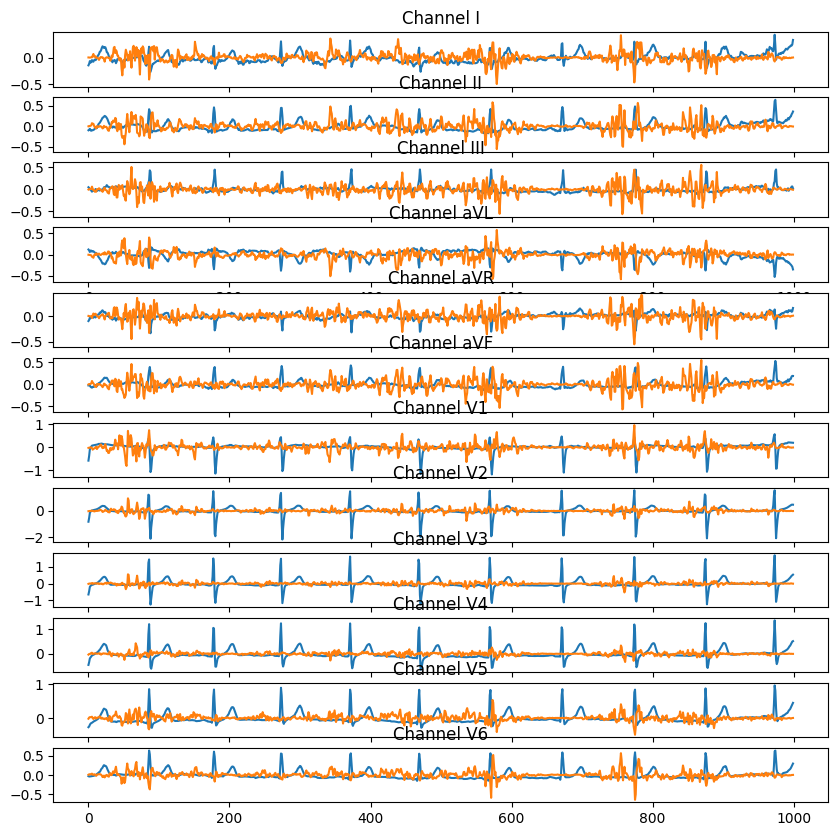

In [100]:
fig,ax = plt.subplots(12,1,figsize=(10,10))
chan = {0:'I',1:'II',2:'III',3:'aVL',4:'aVR',5:'aVF',6:'V1',7:'V2',8:'V3',9:'V4',10:'V5',11:'V6'}
for i in range(12):
    ax[i].plot(input[0][i])
    ax[i].plot(x[0][i])
    ax[i].set_title(f'Channel {chan[i]}')


In [ ]:
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients  = {}
def getGradients(name):
    def hook(model, input, output):
        gradients[name] = output
    return hook
def guided_gradcam(mod,input):
    input = torch.tensor(input).permute(0,2,1).type(torch.FloatTensor).to(torch.device('cuda'))
    input.requires_grad = True
    pred = mod(input)
    pred[0][1].backward(retain_graph=True)
    x = input.grad
    x = x.cpu().numpy()
    guided_out = x
    input = input.detach().cpu().numpy()
    return input, guided_out


In [21]:
df = dataset.data['diagnostic_superclass']

In [23]:
df['Norm'] = df.diagnostic_superclass['Normal']

AttributeError: 'Series' object has no attribute 'diagnostic_superclass'

In [24]:
csv = 'physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv'
root_dir = 'physionet.org/files/ptb-xl/1.0.3'
scp_csv = 'physionet.org/files/ptb-xl/1.0.3/scp_statements.csv'
dic = {'NORM':0,'MI':1,'STTC':2,'CD':3,'HYP':4}
df = pd.read_csv(csv)
agg_df = pd.read_csv(scp_csv, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
def aggregate_diagnostic(y_dic):
      tmp = 0
      for key in y_dic.keys():
          if key in agg_df.index:
              if agg_df.loc[key].diagnostic_class == key_set:
                tmp  = 1

      
      return tmp

df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
for key_set in dic.keys():
    df[key_set] = df.scp_codes.apply(aggregate_diagnostic)

In [95]:
Mi_indices = df[df['MI'] == 1].index

In [96]:
Mi_indices

Int64Index([    7,    38,    49,    62,    76,   102,   105,   130,   138,
              144,
            ...
            21757, 21760, 21766, 21772, 21776, 21781, 21785, 21787, 21788,
            21789],
           dtype='int64', length=5469)